# Acondicionamiento de imágenes 

---

## Objetivo 

Esta práctica de laboratorio tiene como objetivo primordial que podamos comprender los conceptos fundamentales, así como las técnicas básicas de filtrado relacionadas con el tratamiento o procesamiento digital de imágenes. Abordaré los diferentes conceptos con su definición y ejemplos prácticos desarrollados en Python para que asimilemos rápidamente dichos conceptos. Nos centraremos en el acondicionamiento de imágenes, ruido, para posteriormente centrarnos en el proceso de filtrado que es empleado computacionalmente para reducir el efecto de ruido causado en imágenes. Expondré diferentes ejemplos con desarrollos personales así como la comparación de resultados contra la librería desarrollada por OpenCV. Después de ello también abordaremos como una imagen puede ser mejorada a través de la modificación de su histograma.

---

## Ruido en imagenes

Las imágenes al ser adquiridas usualmente vienen contaminadas con algún tipo de ruido. El ruido puede deberse a varias causas, por ejemplo, durante el proceso de adquisición. Al tomar varias imágenes de una misma escena, a través del mismo captor, aun en situaciones controladas, uno puede darse cuenta de que el valor de un píxel a lo largo de la secuencia de imágenes no es el mismo.

In [1]:
#Importaremos las librerias necesarias para este laboratorio #1
import cv2 as cv                     #Libreria desarrollada por OPENCV
import matplotlib.pyplot as plt      #Libreria especializada en realizar graficos y análisis de datos 
import numpy as np                   #Libreria especializada en vectores y matrices de distintas magnitudes
from skimage.metrics import structural_similarity as ssim  #Paquete especializado en IA y manipulación de imagenes
import math                          #Brinda funciones para cálculos matematicos 

In [2]:
#Usamos función para lectura de imágenes
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.show() 

In [3]:
#Lectura de imágenes
img01 = cv.imread('CochesVarios/coche17.jpeg')
img01 = cv.cvtColor(img01,cv.COLOR_BGR2GRAY)
img02 = cv.imread('CochesVarios/coche03.jpeg')
img02 = cv.cvtColor(img02,cv.COLOR_BGR2GRAY)

---

### Sal & Pimienta

Se define como un tipo de ruido que algunas veces acompaña a las imágenes de entrada es el llamado ruido de sal y pimienta. Este tipo de ruido se caracteriza por saturar el valor de uno o más píxeles de una imagen hacia el límite positivo (sal) o hacia el límite inferior (pimienta).

In [4]:
#En este paso vamos a agregar ruido a nuestras imagenes
probabilidad = 0.20 #𝜎 ruido con una media y una sigma
img01_cr = img01.copy()
ruido_img01 = np.random.rand(*img01.shape)

In [5]:
img01_cr[ruido_img01 < probabilidad/2] = 255
img01_cr[ruido_img01 > 1-probabilidad/2] = 0

---

### Ruido de pimienta aleatorio

Para la segunda imagen trabajamos cambiando la condición de distribución del ruido, de una manera aleatoria solamente colocando pimienta con una probabilidad de 0.30 es decir cada píxel con esta anomalía será saturada al límite inferior.

In [6]:
probabilidad_2 = 0.30 #𝜎 ruido con una media y una sigma
img02_cr = img02.copy()
ruido_img02 = np.random.rand(*img02.shape)

In [7]:
img02_cr[ruido_img02 < probabilidad_2] = 0

---

### Filtrado por OpenCV

Utilizaremos, Median Blur de OpenCV el cual investigando en el sitio de OpenCV, pude comprender que:
* Tiene buen desempeño preservando los bordes mientras remueve ruido en la imagen.
* Está bien catalogado por el desempeño que tiene para remover sal & pimienta.

In [8]:
#Asignamos la imagen a la función de median blur, y colocamos el parámetro de apertura.
img01_blur = cv.medianBlur(img01_cr,5) 
img02_blur = cv.medianBlur(img02_cr,5)

---

### Filtrado sin OpenCV (Manual)

En esta parte desarrollaré código para filtrar las imágenes con ruido (Sal & pimienta y aleatorio), y posteriormente comparar con el filtrado realizado con OpenCV. Se utilizará un filtro mediana que según las bibliografías es el que ha dado mejores resultados para eliminar este tipo de anomalías, debido a que reemplaza el valor de cada píxel, por la mediana de los píxeles circundantes es decir preserva los bordes de la imagen.

In [9]:
#En esta propuesta de eliminación de ruido trataremos de utilizar un filtro de mediana, que es similar al median blur de openCV.
def med_prop (imagen, kernel):      #Kernel (borde = kernel //2)
    borde = kernel // 2            #Aseguramos que el kernel se ajuste, completamente los píxeles de la imagen sin excederse de su límite.
    filas, cols = (img01_cr.shape)     #
    img_med_fil = np.zeros((filas - 2 * borde, cols - 2 * borde), dtype=np.uint8)  #Evitamos problemas de borde con np.zeros reduciendo img. 
                                                            #hacemos recorrido de cada pixel, iniciando en (2,2) y termina en (-2,-2)
    for i in range(borde, filas - borde):                   #dtype=np.uint8, enteros sin signo de 8 bits, estandar para imagenes b&n
        for j in range(borde, cols - borde):
            ventana = imagen[i - borde:i + borde + 1, j - borde:j + borde + 1] #Se extrae ventana
            img_med_fil[i - borde, j - borde] = np.median(ventana)              #Se calcula la media
    
    return img_med_fil                                                          #Se obtiene filtro

img_fil_med_man= med_prop (img01_cr,5)                                          #se aplica filtro de media img01
img_fil_med_man2= med_prop (img02_cr,5)                                         #se aplica filtro de media. img02

---

### Muestra & analisis de resultados

En la siguiente parte abordaremos el análisis de resultados, así como los cálculos de error entre OpenCV y nuestro método de filtro mediana manual. Para ello nos apoyaremos en los cálculos ahora mencionados.

- Error cuadrático medio **(MSE)**: MSE mide la diferencia cuadrática media entre los valores de los píxeles de dos imágenes. Es un índice de similitud básico pero ampliamente utilizado.

- Índice de similitud estructural **(SSIM)**: SSIM evalúa la similitud estructural entre dos imágenes teniendo en cuenta la luminancia, el contraste y la estructura. Se suele utilizar para evaluar la calidad percibida de una imagen en comparación con una imagen de referencia.

- Relación señal-ruido máxima **(PSNR)**: PSNR es una medida de la calidad de una imagen comprimida o reconstruida en comparación con la imagen original. Cuantifica la cantidad de ruido o distorsión presente.

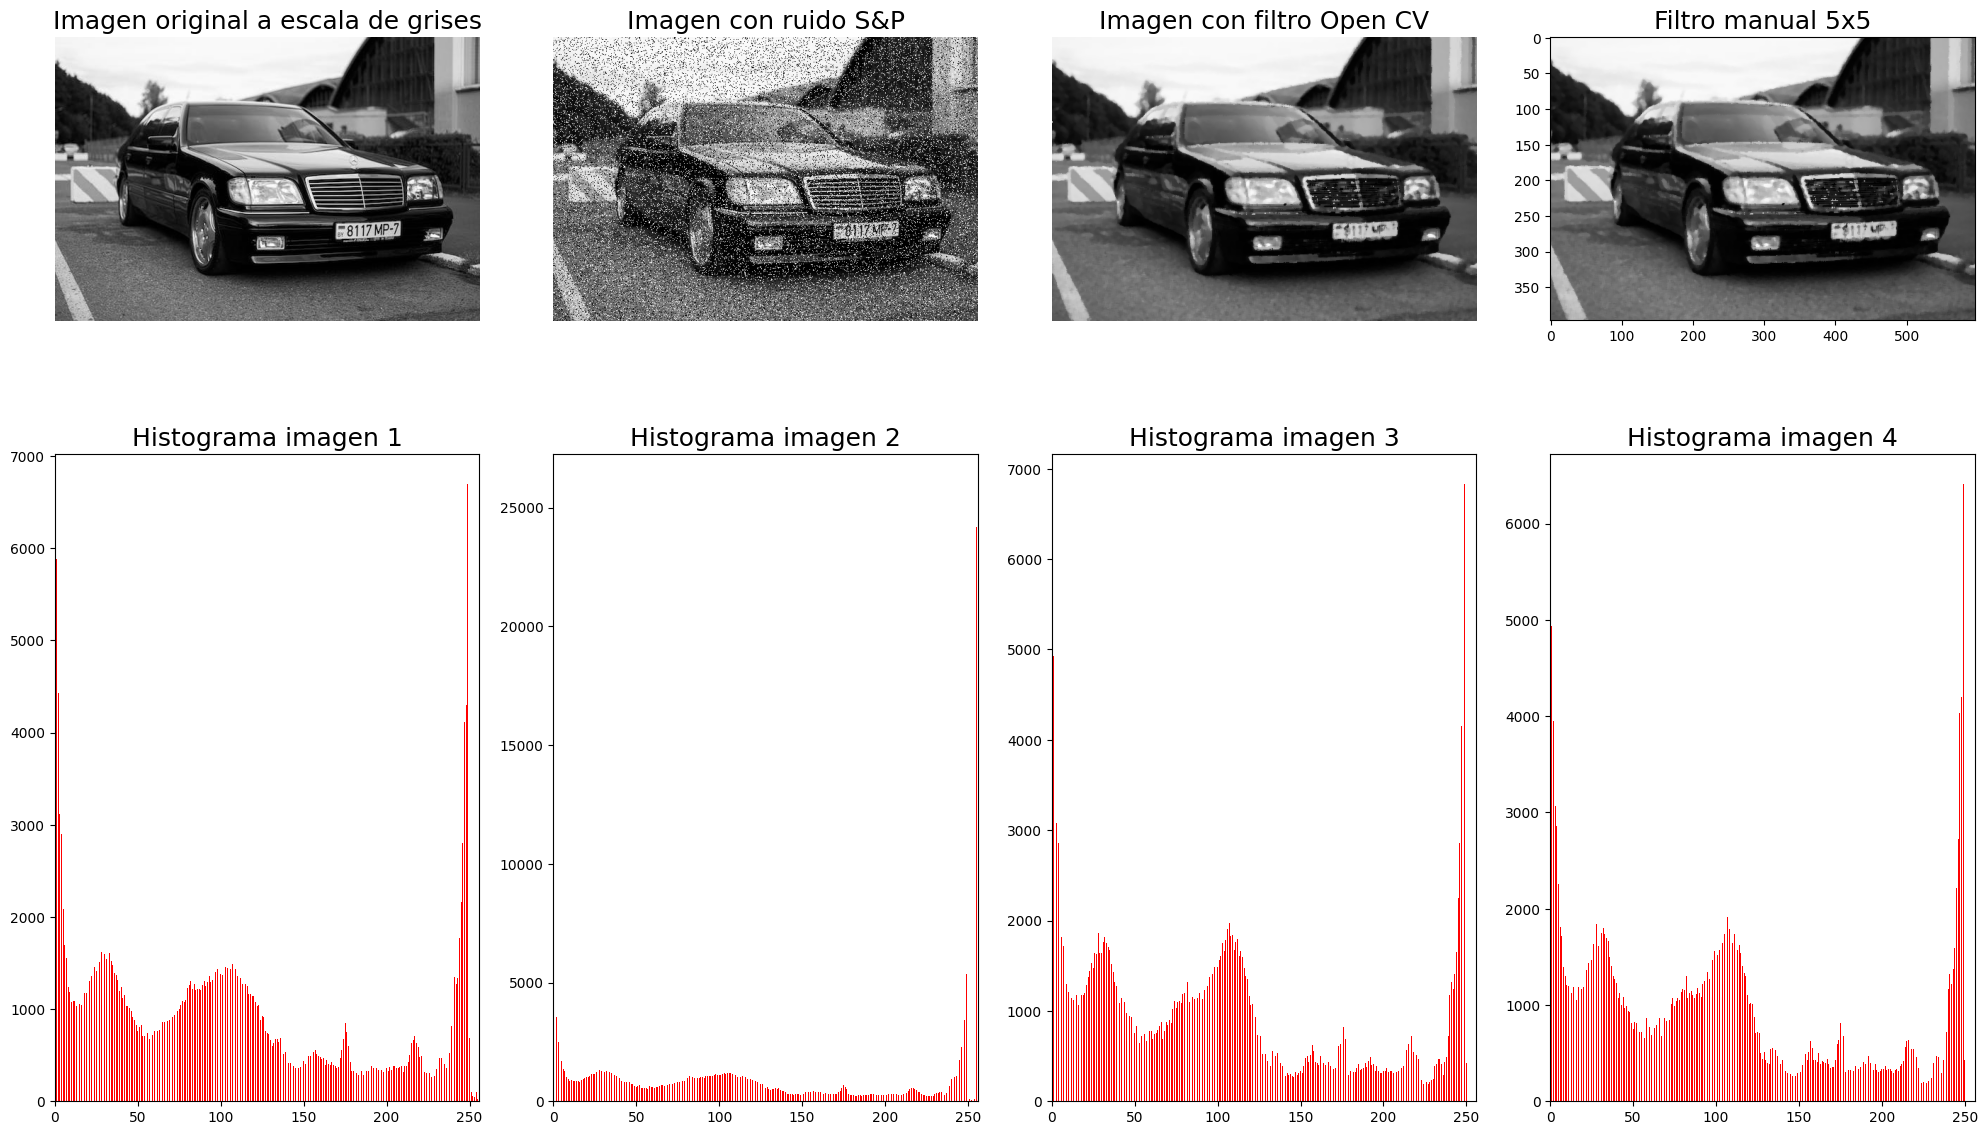

>>>  MSE con filtro manual de media 5x5: 35.06423173803527  <<<
>>>  MSE con filtro de media OpenCV: 35.00821280133001  <<<
>>>  PSNR con filtro manual de media 5x5: 32.682160329785276 dB  <<<
>>>  PSNR con filtro de media OpenCV: 32.68910420635074 dB  <<<
>>>  SSIM con filtro manual de media 5x5: 0.7629096473321392  <<<
>>>  SSIM con filtro de media OpenCV: 0.7626631377701624  <<<


In [20]:
# Mostraremos los resultados obtenidos en este laboratorio.
plt.figure(figsize=(20, 13))

#Inicializa el histograma 1
hist_img01_1 = [0 for i in range(0,256)]

#Obtiene las dimensiones de la imagen
filas_ecu, cols_ecu = img01.shape

#Conteo de niveles de gris
for i in range(filas_ecu):
    for j in range(cols_ecu):

        color = img01[i,j]
        hist_img01_1[color]+=1

#Inicializa el histograma 2
hist_img01_2 = [0 for i in range(0,256)]

#Obtiene las dimensiones de la imagen
filas_ecu, cols_ecu = img01_cr.shape

#Conteo de niveles de gris
for i in range(filas_ecu):
    for j in range(cols_ecu):

        color = img01_cr[i,j]
        hist_img01_2[color]+=1

#Inicializa el histograma 3
hist_img01_3 = [0 for i in range(0,256)]

#Obtiene las dimensiones de la imagen
filas_ecu, cols_ecu = img01_blur.shape

#Conteo de niveles de gris
for i in range(filas_ecu):
    for j in range(cols_ecu):

        color = img01_blur[i,j]
        hist_img01_3[color]+=1

#Inicializa el histograma 4
hist_img01_4 = [0 for i in range(0,256)]

#Obtiene las dimensiones de la imagen
filas_ecu, cols_ecu = img_fil_med_man.shape

#Conteo de niveles de gris
for i in range(filas_ecu):
    for j in range(cols_ecu):

        color = img_fil_med_man[i,j]
        hist_img01_4[color]+=1
#Todo los valores para mostrar imagenes resultantes y sus histogramas son declarados a continuación.
plt.subplot(2, 4, 1)
plt.imshow(cv.cvtColor(img01,cv.COLOR_BGR2RGB))
plt.title("Imagen original a escala de grises", size=18)
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(cv.cvtColor(img01_cr, cv.COLOR_BGR2RGB))
plt.title("Imagen con ruido S&P", size=18)
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(cv.cvtColor(img01_blur, cv.COLOR_BGR2RGB))
plt.title("Imagen con filtro Open CV", size=18)
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(cv.cvtColor(img_fil_med_man, cv.COLOR_BGR2RGB))
plt.title("Filtro manual 5x5", size=18)
plt.axis('on')

plt.subplot(2, 4, 5)
plt.bar(range(256),hist_img01_1,color='red',width=0.5)
plt.title("Histograma imagen 1", size=18)
plt.xlim([0,256])

plt.subplot(2, 4, 6)
plt.bar(range(256),hist_img01_2,color='red',width=0.5)
plt.title("Histograma imagen 2", size=18)
plt.xlim([0,256])

plt.subplot(2, 4, 7)
plt.bar(range(256),hist_img01_3,color='red',width=0.5)
plt.title("Histograma imagen 3", size=18)
plt.xlim([0,256])

plt.subplot(2, 4, 8)
plt.bar(range(256),hist_img01_4,color='red',width=0.5)
plt.title("Histograma imagen 4", size=18)
plt.xlim([0,256])

plt.tight_layout()
plt.show()

#Cálculo de MSE (Error cuadrático medio)

def mse (img_ori, img_fil):
    dif = img_ori - img_fil     # Calcula la diferencia entre las imágenes
    sqr_dif = np.square(dif)    # Eleva al cuadrado las diferencias
    mse = np.mean(sqr_dif)      # Calcula el promedio de los valores
    return mse
    

mse_manual = mse(img01[2:-2, 2:-2], img_fil_med_man) #Obtenemos MSE para imagen filtro manual

if np.shape(img01[2:-2, 2:-2]) != img_fil_med_man.shape:
    raise ValueError("Las imágenes deben tener el mismo tamaño para realizar cálculo MSE")  #Error programado 
    
mse_opencv = mse(img01, img01_blur)                  #Obtenemos MSE para imagen filtro openCV

if img01.shape != img01_blur.shape:
    raise ValueError("Las imágenes deben tener el mismo tamaño para realizar cálculo MSE")  #Error programado 

#Cálculo de PSNR (Proporción Máxima de Señal a Ruido)
max_pixel = 255.0
psnr_man = 20 * math.log10(max_pixel / math.sqrt(mse_manual)) #Si MSE=0, significa que no hay ruido presente en la señal.
psnr_ocv = 20 * math.log10(max_pixel / math.sqrt(mse_opencv))  # Por lo tanto, los PSNR no tienen importancia.

#Cálculo SSIM 
                                    
ssim_man = ssim(img01[2:-2, 2:-2], img_fil_med_man, multichannel=True) 

if np.shape(img01[2:-2, 2:-2]) != img_fil_med_man.shape:
    raise ValueError("Las imágenes deben tener el mismo tamaño para realizar cálculo SSIM") #Error programado 

ssim_ocv = ssim(img01, img01_blur, multichannel=True) 

if img01.shape != img01_blur.shape:
    raise ValueError("Las imágenes deben tener el mismo tamaño para realizar cálculo SSIM") #Error programado 

# Mostrar los resultados de errores
print(f'>>>  MSE con filtro manual de media 5x5: {mse_manual}  <<<')
print(f'>>>  MSE con filtro de media OpenCV: {mse_opencv}  <<<')
print(f'>>>  PSNR con filtro manual de media 5x5: {psnr_man} dB  <<<') 
print(f'>>>  PSNR con filtro de media OpenCV: {psnr_ocv} dB  <<<')
print(f'>>>  SSIM con filtro manual de media 5x5: {ssim_man}  <<<') 
print(f'>>>  SSIM con filtro de media OpenCV: {ssim_ocv}  <<<')


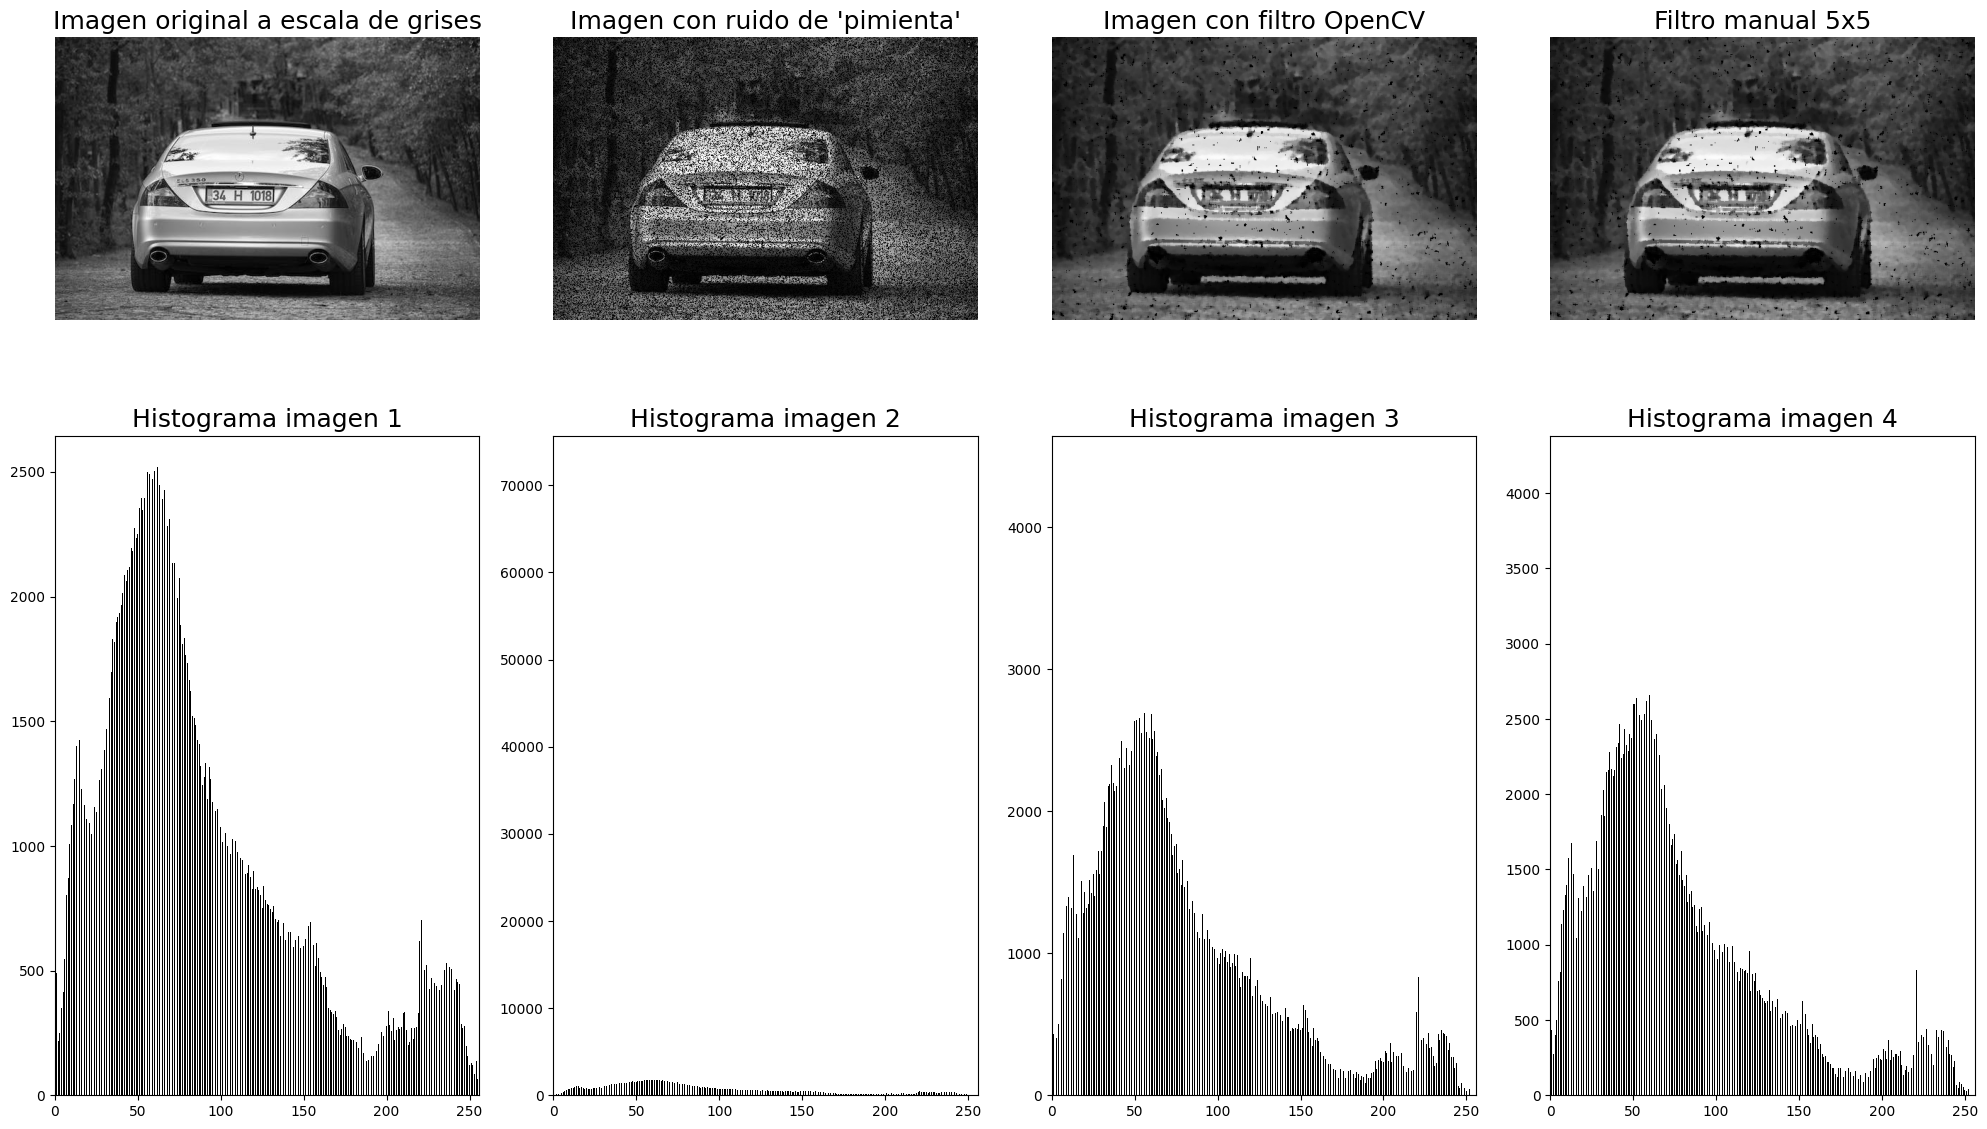

>>>  MSE con filtro manual de media 5x5: 54.20559819451253  <<<
>>>  MSE con filtro de media OpenCV: 54.215408333333336  <<<
>>>  PSNR con filtro manual de media 5x5: 30.790362193584137 dB  <<<
>>>  PSNR con filtro de media OpenCV: 30.789576277772312 dB  <<<
>>>  SSIM con filtro manual de media 5x5: 0.6154559214866018  <<<
>>>  SSIM con filtro de media OpenCV: 0.6146088762668095  <<<


In [21]:
# Mostraremos los resultados obtenidos en este laboratorio.
plt.figure(figsize=(20, 13))

#Inicializa el histograma 1
hist_img02_1 = [0 for i in range(0,256)]

#Obtiene las dimensiones de la imagen
filas_ecu, cols_ecu = img02.shape

#Conteo de niveles de gris
for i in range(filas_ecu):
    for j in range(cols_ecu):

        color = img02[i,j]
        hist_img02_1[color]+=1

#Inicializa el histograma 2
hist_img02_2 = [0 for i in range(0,256)]

#Obtiene las dimensiones de la imagen
filas_ecu, cols_ecu = img02_cr.shape

#Conteo de niveles de gris
for i in range(filas_ecu):
    for j in range(cols_ecu):

        color = img02_cr[i,j]
        hist_img02_2[color]+=1

#Inicializa el histograma 3
hist_img02_3 = [0 for i in range(0,256)]

#Obtiene las dimensiones de la imagen
filas_ecu, cols_ecu = img02_blur.shape

#Conteo de niveles de gris
for i in range(filas_ecu):
    for j in range(cols_ecu):

        color = img02_blur[i,j]
        hist_img02_3[color]+=1

#Inicializa el histograma 4
hist_img02_4 = [0 for i in range(0,256)]

#Obtiene las dimensiones de la imagen
filas_ecu, cols_ecu = img_fil_med_man2.shape

#Conteo de niveles de gris
for i in range(filas_ecu):
    for j in range(cols_ecu):

        color = img_fil_med_man2[i,j]
        hist_img02_4[color]+=1


plt.subplot(2, 4, 1)
plt.imshow(cv.cvtColor(img02,cv.COLOR_BGR2RGB))
plt.title("Imagen original a escala de grises", size=18)
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(cv.cvtColor(img02_cr, cv.COLOR_BGR2RGB))
plt.title("Imagen con ruido de 'pimienta'",size=18)
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(cv.cvtColor(img02_blur, cv.COLOR_BGR2RGB))
plt.title("Imagen con filtro OpenCV",size=18)
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(cv.cvtColor(img_fil_med_man2, cv.COLOR_BGR2RGB,))
plt.title("Filtro manual 5x5", size=18)
plt.axis('off')

plt.subplot(2, 4, 5)
plt.bar(range(256),hist_img02_1,color='black',width=0.5)
plt.title("Histograma imagen 1", size=18)
plt.xlim([0,256])

plt.subplot(2, 4, 6)
plt.bar(range(256),hist_img02_2,color='black',width=0.5)
plt.title("Histograma imagen 2", size=18)
plt.xlim([0,256])

plt.subplot(2, 4, 7)
plt.bar(range(256),hist_img02_3,color='black',width=0.5)
plt.title("Histograma imagen 3", size=18)
plt.xlim([0,256])

plt.subplot(2, 4, 8)
plt.bar(range(256),hist_img02_4,color='black',width=0.5)
plt.title("Histograma imagen 4", size=18)
plt.xlim([0,256])

plt.tight_layout()
plt.show()

#Cálculo de MSE (Error cuadrático medio)
def mse (img_ori, img_fil):
    dif = img_ori - img_fil    # Calcula la diferencia entre las imágenes
    sqr_dif = np.square(dif)    # Eleva al cuadrado las diferencias
    mse = np.mean(sqr_dif)      # Calcula el promedio de los valores
    return mse

mse_manual = mse(img02[2:-1, 2:-2], img_fil_med_man2) #Obtenemos MSE para imagen filtro manual

if np.shape(img02[2:-1, 2:-2]) != img_fil_med_man2.shape:
    raise ValueError("Las imágenes deben tener el mismo tamaño para realizar cálculo MSE") #Error programado 
    
mse_opencv = mse(img02, img02_blur) #Obtenemos MSE para imagen filtro openCV

if img02.shape != img02_blur.shape:
    raise ValueError("Las imágenes deben tener el mismo tamaño para realizar cálculo MSE") #Error programado 

#Cálculo de PSNR (Proporción Máxima de Señal a Ruido)

max_pixel = 255.0
psnr_man = 20 * math.log10(max_pixel / math.sqrt(mse_manual))
psnr_ocv = 20 * math.log10(max_pixel / math.sqrt(mse_opencv))

#Cálculo SSIM 
                                    
ssim_man = ssim(img02[2:-1, 2:-2], img_fil_med_man2, multichannel=True)

if np.shape(img02[2:-1, 2:-2]) != img_fil_med_man2.shape:
    raise ValueError("Las imágenes deben tener el mismo tamaño para realizar cálculo SSIM") #Error programado 
    
ssim_ocv = ssim(img02, img02_blur, multichannel=True) 

if img02.shape != img02_blur.shape:
    raise ValueError("Las imágenes deben tener el mismo tamaño para realizar cálculo SSIM") #Error programado 
    
# Mostrar los resultados de errores
print(f'>>>  MSE con filtro manual de media 5x5: {mse_manual}  <<<')
print(f'>>>  MSE con filtro de media OpenCV: {mse_opencv}  <<<')
print(f'>>>  PSNR con filtro manual de media 5x5: {psnr_man} dB  <<<') 
print(f'>>>  PSNR con filtro de media OpenCV: {psnr_ocv} dB  <<<')
print(f'>>>  SSIM con filtro manual de media 5x5: {ssim_man}  <<<') 
print(f'>>>  SSIM con filtro de media OpenCV: {ssim_ocv}  <<<')


---

## Ajuste de intensidad

Algunas veces las imágenes adquiridas por los sistemas de visión, por ejemplo, de un robot pueden venir acompañadas no solamente de anomalías, mismas que ya abordamos anteriormente, sino que, con poco contraste. Aparte de percatarnos visualmente de que está poco contrastada, si analizamos su histograma de la misma imagen podremos de igual manera corroborarlo. El cual puede aparecer comprimido, cargado a la izquierda, al centro o a la derecha.

In [12]:
img03_ori = cv.imread('CochesVarios/coche11.jpeg', cv.IMREAD_GRAYSCALE)

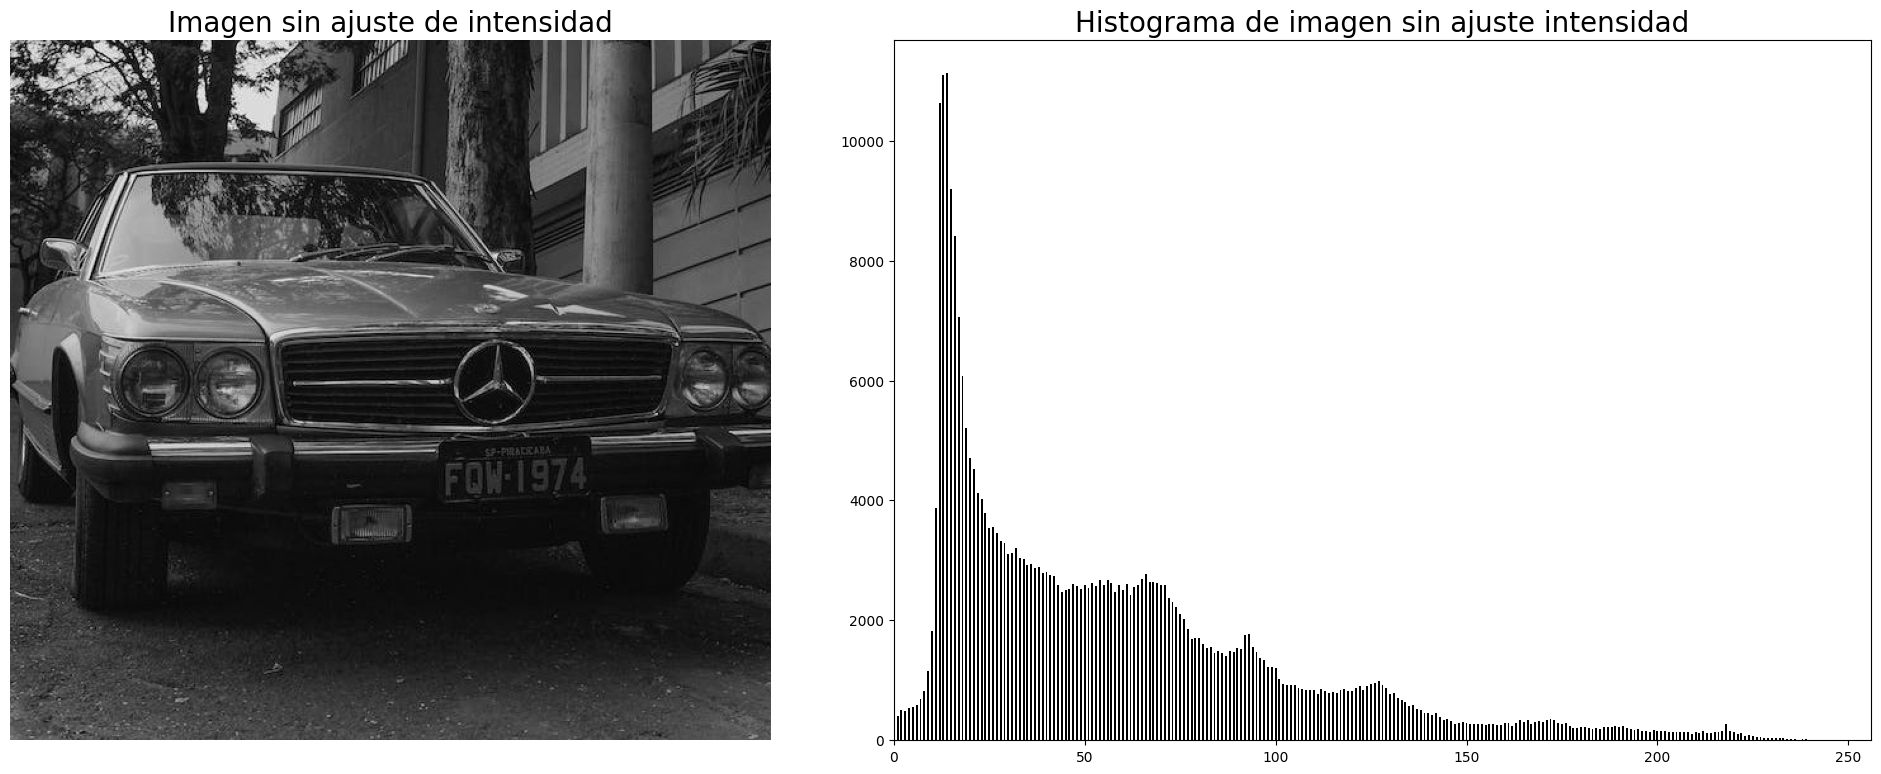

In [23]:
#Inicializa el histograma para imagen a ecualizar
hist_img03_in = [0 for i in range(0,256)]
#Obtiene las dimensiones de la imagen
filas_ecu, cols_ecu = img03_ori.shape
#Conteo de niveles de gris
for i in range(filas_ecu):
    for j in range(cols_ecu):

        color = img03_ori[i,j]
        hist_img03_in[color]+=1

#Mostramos imagen sin ecualizar y su histograma inicial
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.imshow(img03_ori, cmap='gray')
plt.title("Imagen sin ajuste de intensidad", size=20)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.bar(range(256),hist_img03_in,color='black',width=0.5)
plt.title("Histograma de imagen sin ajuste intensidad", size=20)
plt.xlim([0,256])
# Mostrar el gráfico
plt.tight_layout()
plt.show()


### Ajuste de intensidad por OpenCV

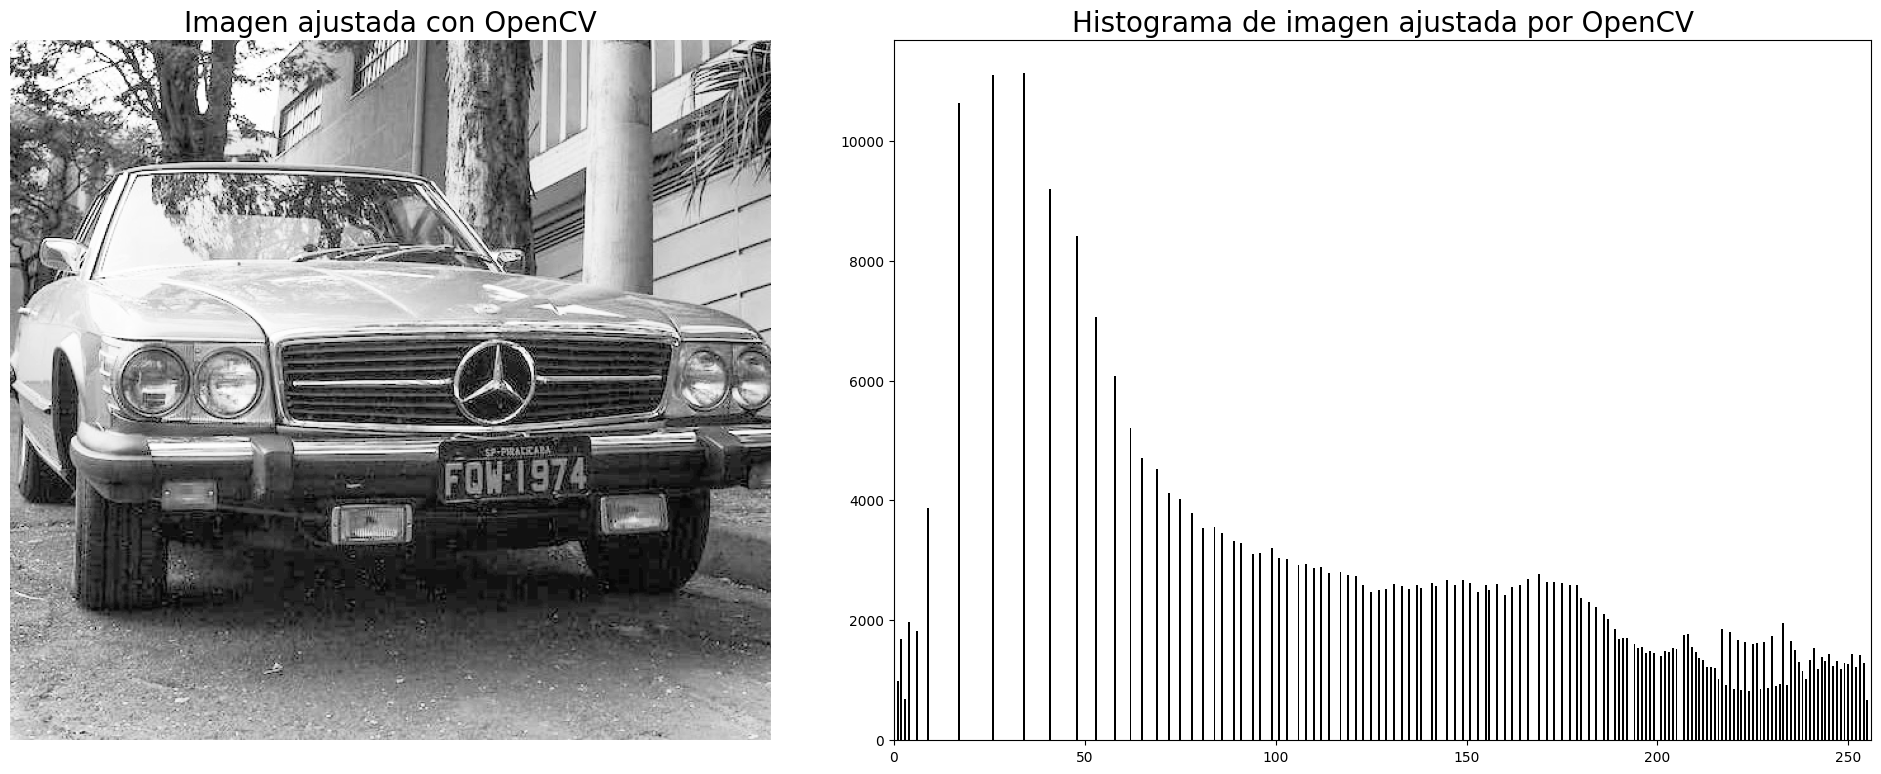

In [33]:
#Ajuste de imagen de entrada por OpenCV nos apoyaremos en la funcion (cv.equalizeHist) para el ajuste
#por openCV el cual ajusta la imagen con base a su histograma.
img_ai_ocv = cv.equalizeHist(img03_ori)
hist_img_ai_ocv = cv.calcHist([img_ai_ocv], [0], None, [256], [0, 256])
hist_img_ai_ocv = hist_img_ai_ocv.ravel()  

#Mostramos imagen ajustada con openCV y su histograma 
plt.figure(figsize=(20, 15))

plt.subplot(2,2,1)
plt.imshow(img_ai_ocv, cmap='gray')
plt.title("Imagen ajustada con OpenCV", size=20)
plt.axis('off')

plt.subplot(2,2,2)
plt.bar(range(256),hist_img_ai_ocv,color='black', width=0.5)
plt.title("Histograma de imagen ajustada por OpenCV", size=20)
plt.xlim([0,256])

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Ajuste de intensidad sin OpenCV (Manual)

Utilizaremos una función de distribución acumulativa **(CDF)** para ecualizar los niveles de gris, haciendo más uniforme la distribución de los rangos de niveles de gris. La **(CDF)** la obtenemos acumulando las frecuencias del histograma normalizado (para ello, debemos dividir cada valor del histograma por el número de píxeles), representa la probabilidad acumulada de encontrar un valor de intensidad menor o igual a un valor dado. Una vez apliquemos el **CDF** lograremos distribuir de mejor manera los nuevos valores de cada píxel, mejorando los contrastes que hacen sean más notorios los detalles de la imagen, mejorando así su calidad visual.

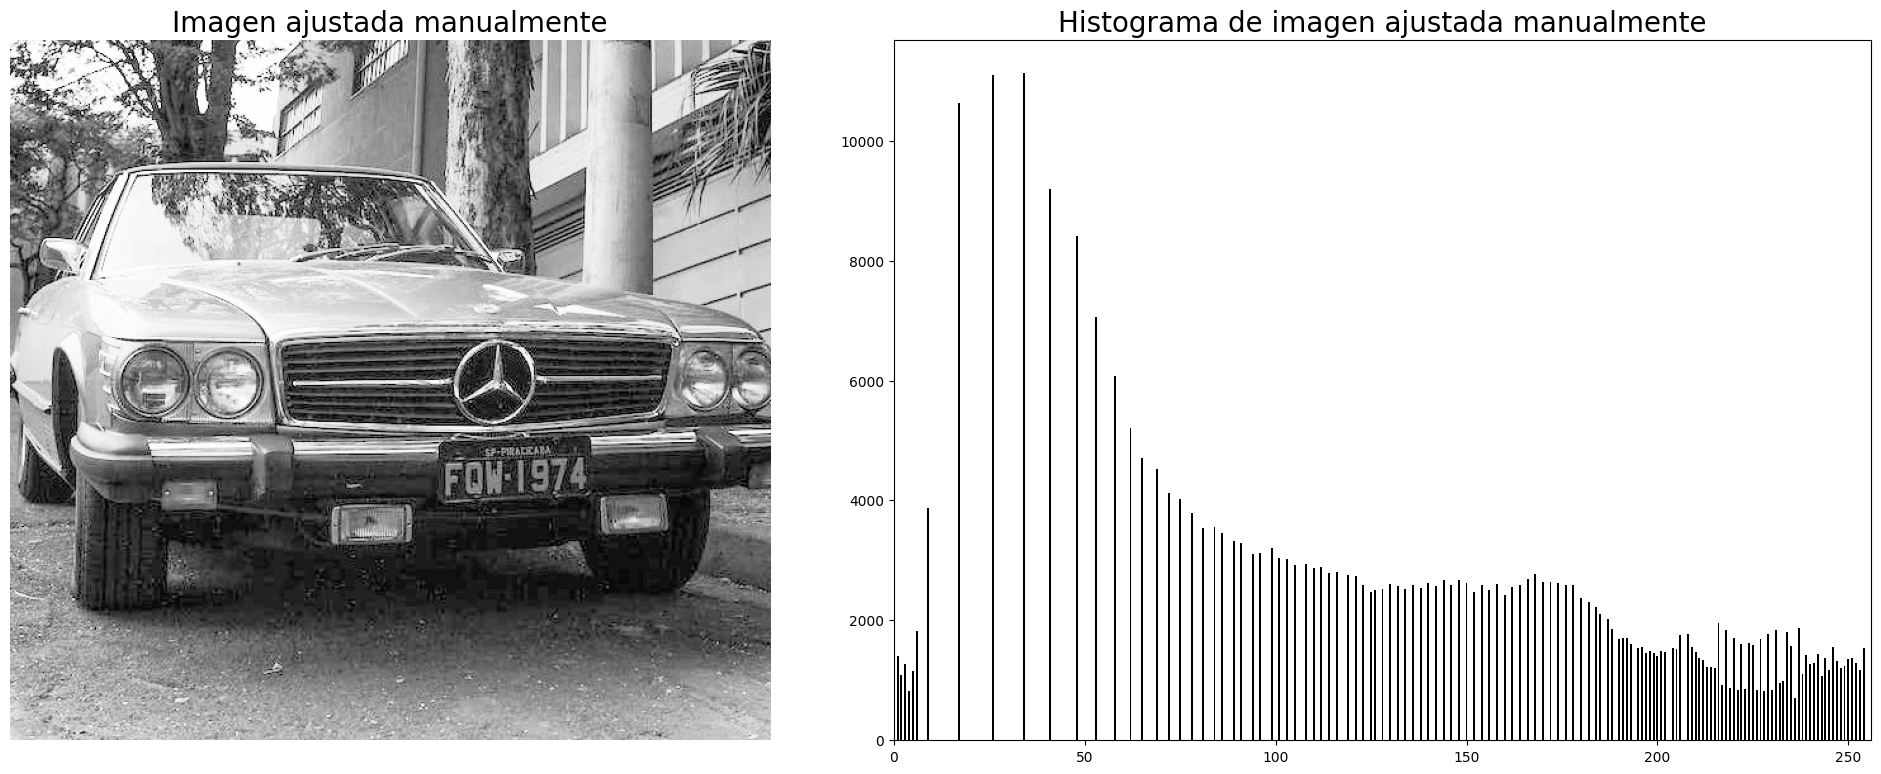

In [34]:
#Utilizaremos el histograma de la imagen original para realizar el ajuste mediante una array en numpy para facilitar los cálculos  
#En el método con el algoritmo openCV tambien se ajusto con base al histograma de la imagen original.
hist_img03_in_array = np.array (hist_img03_in)
# Calcular CDF (función de distribución acumulada) 
pdf = hist_img03_in_array / (filas_ecu * cols_ecu)
cdf = np.cumsum(pdf)
cdf_n = cdf * 255 / cdf[-1]  # Escalar CDF al rango [0, 255], y dividir cada valor del histograma por el número de píxeles

img_03_man = np.zeros_like(img03_ori)
for i in range(filas_ecu):
    for j in range(cols_ecu):  #imagen de salida ecualizada por reasignación de los valores de los píxeles
        img_03_man[i, j] = cdf_n[img03_ori[i, j]]

# Calcular el histograma de la imagen ecualizada sin openCV
hist_img03_out = [0 for i in range(256)]
for i in range(filas_ecu):
    for j in range(cols_ecu):
        color = img_03_man[i, j]
        hist_img03_out[int(color)] += 1
        
plt.figure(figsize=(20, 15))

plt.subplot(2,2,1)
plt.imshow(img_03_man, cmap='gray')
plt.title("Imagen ajustada manualmente", size=20)
plt.axis('off')

plt.subplot(2,2,2)
plt.bar(range(256), hist_img03_out,color='black',width=0.5)
plt.title("Histograma de imagen ajustada manualmente", size=20)
plt.xlim([0,256])        

# Mostrar el gráfico
plt.tight_layout()
plt.show()

---

## Comparativas de imágenes resultantes y sus histogramas

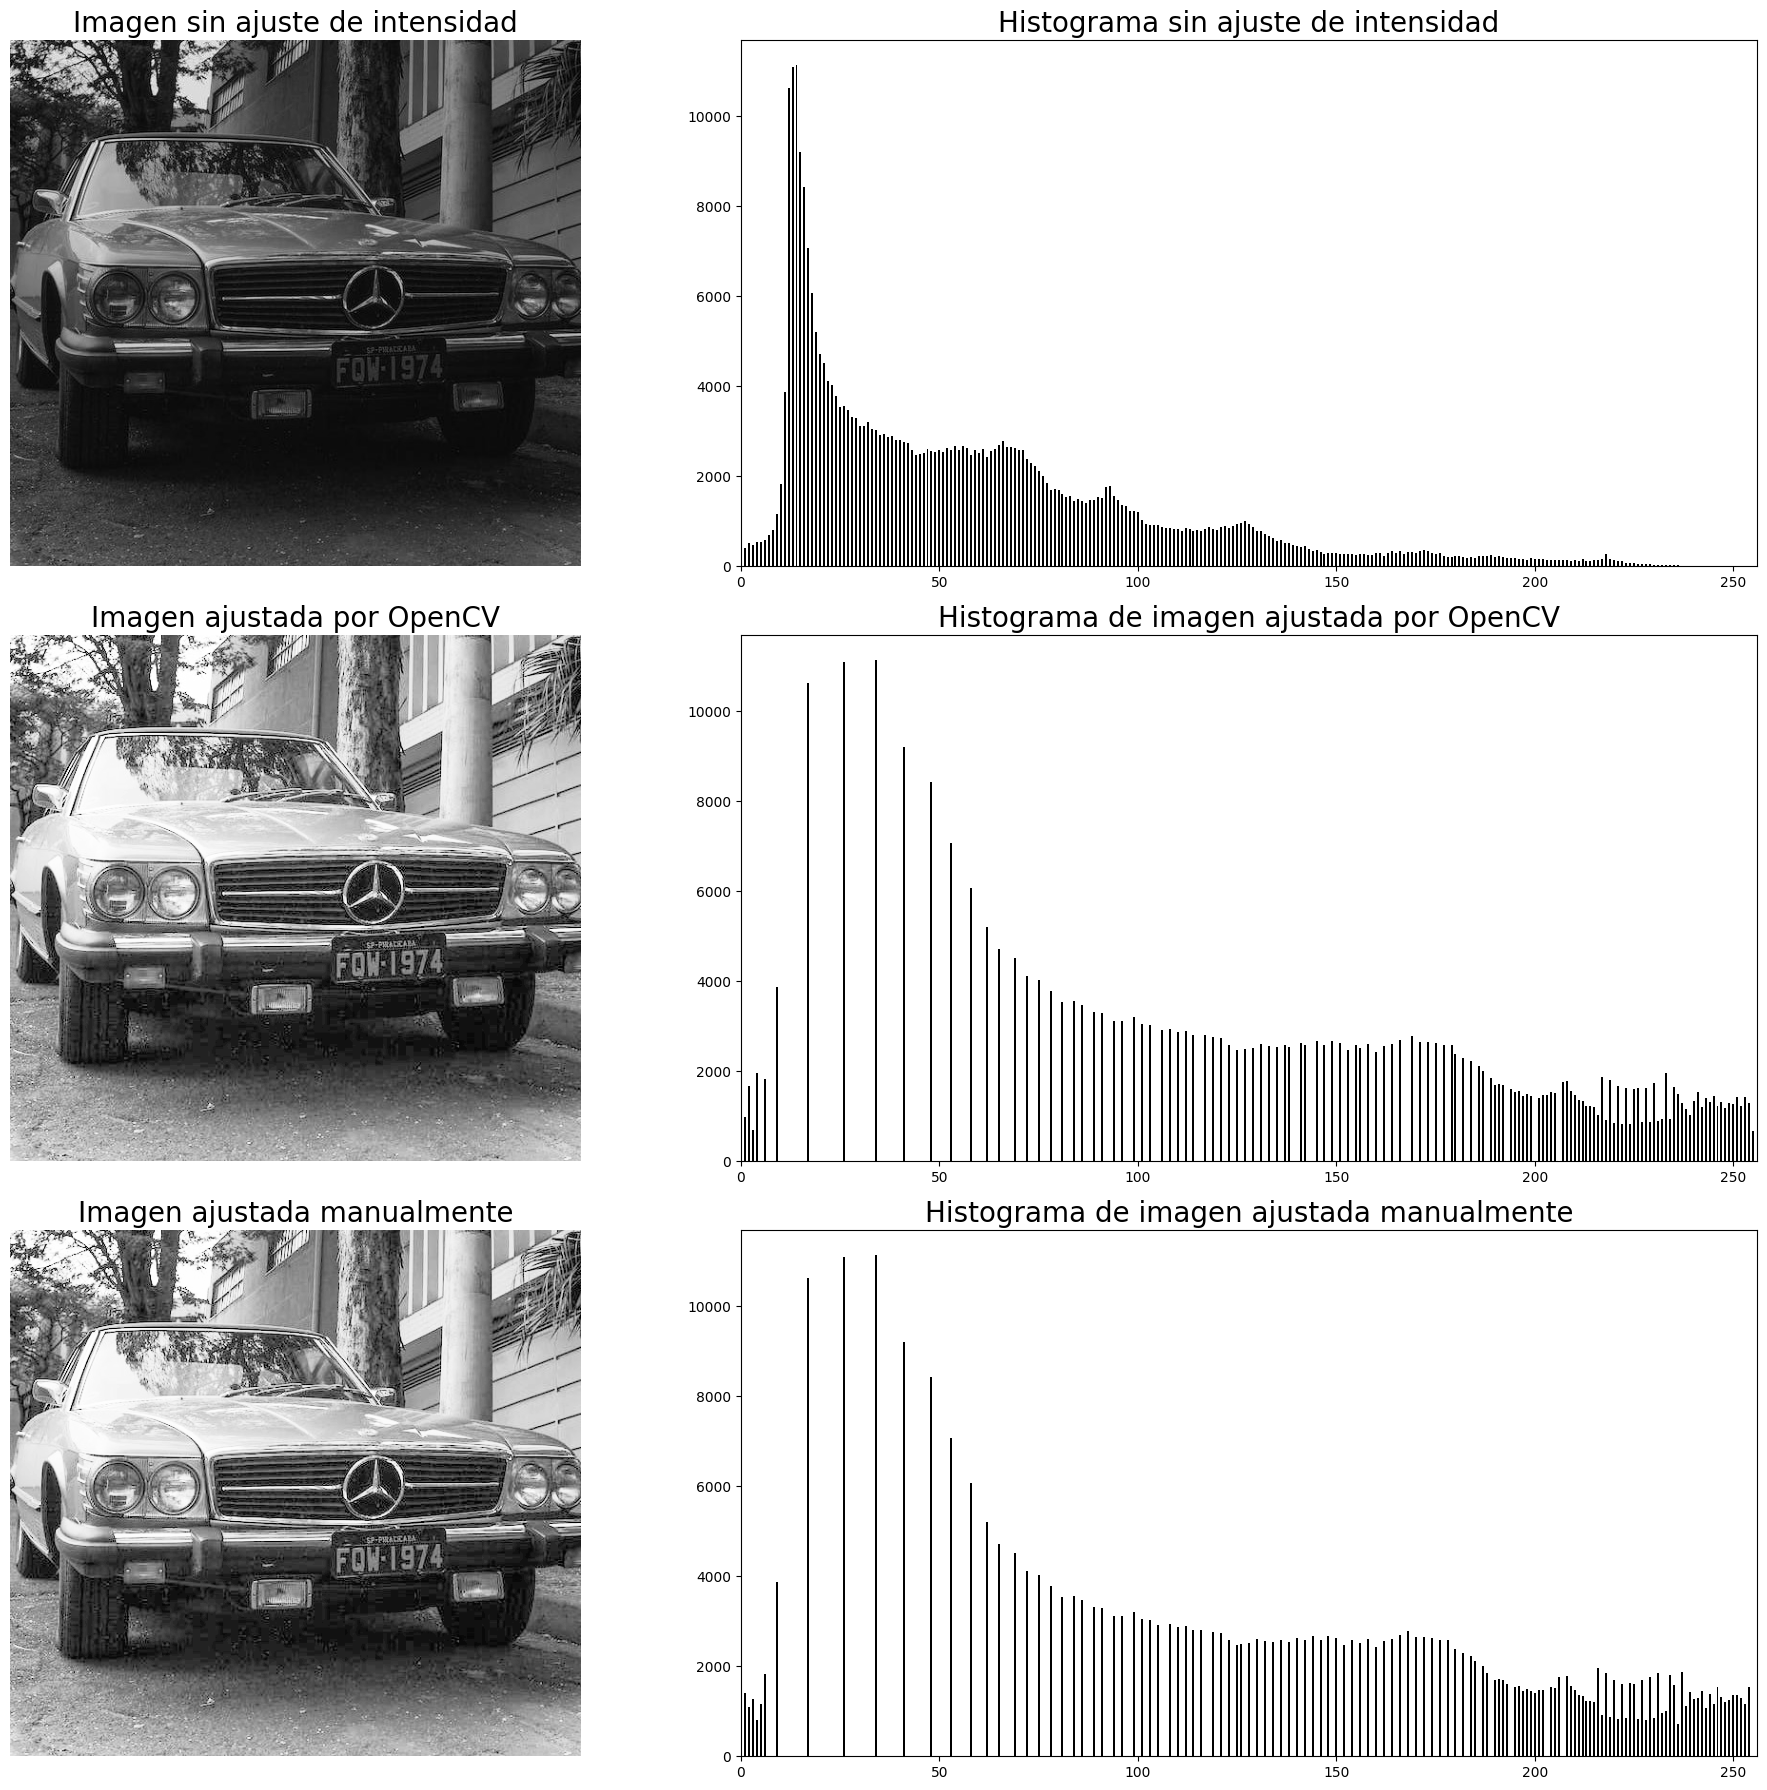

In [37]:
#Mostraremos imágenes resultantes, así como sus histogramas para su análisis
plt.figure(figsize=(20, 18))

plt.subplot(3, 2, 1)
plt.imshow(img03_ori, cmap='gray')
plt.title("Imagen sin ajuste de intensidad", size=20)
plt.axis('off')

plt.subplot(3, 2, 2)
plt.bar(range(256),hist_img03_in,color='black',width=0.5)
plt.title("Histograma sin ajuste de intensidad", size=20)
plt.xlim([0,256])

plt.subplot(3,2,3)
plt.imshow(img_ai_ocv, cmap='gray')
plt.title("Imagen ajustada por OpenCV", size=20)
plt.axis('off')

plt.subplot(3,2,4)
plt.bar(range(256),hist_img_ai_ocv,color='black', width=0.5)
plt.title("Histograma de imagen ajustada por OpenCV", size=20)
plt.xlim([0,256])

plt.subplot(3,2,5)
plt.imshow(img_03_man, cmap='gray')
plt.title("Imagen ajustada manualmente", size=20)
plt.axis('off')

plt.subplot(3,2,6)
plt.bar(range(256), hist_img03_out,color='black',width=0.5)
plt.title("Histograma de imagen ajustada manualmente", size=20)
plt.xlim([0,256])    

plt.tight_layout()
plt.show()

---

## Conclusiones generales 

1. Los métodos objetivos para evaluar la calidad de la imagen perceptiva tradicionalmente intentaban cuantificar la visibilidad de los errores (diferencias) entre una imagen distorsionada y una imagen de referencia utilizando una variedad de propiedades conocidas del sistema visual humano. Es por ello que empleamos (MSE,SSIM,PSNR), después de aplicar ruido a la imágenes de muestra img01, img02 podemos ver que los valores obtenidos son los siguientes: 

* img01 𝜎=0.2

* MSE con filtro manual de media 5x5: 54.20559819451253 
* MSE con filtro de media OpenCV: 54.215408333333336 
* PSNR con filtro manual de media 5x5: 30.790362193584137 dB 
* PSNR con filtro de media OpenCV: 30.789576277772312 dB 
* SSIM con filtro manual de media 5x5: 0.6154559214866018  
* SIM con filtro de media OpenCV: 0.6146088762668095  

* img02 𝜎=0.3

* MSE con filtro manual de media 5x5: 54.20559819451253  
* MSE con filtro de media OpenCV: 54.215408333333336  
* PSNR con filtro manual de media 5x5: 30.790362193584137 dB  
* PSNR con filtro de media OpenCV: 30.789576277772312 dB  
* SSIM con filtro manual de media 5x5: 0.6154559214866018  
* SSIM con filtro de media OpenCV: 0.6146088762668095  

* En el caso de la MSE puedo decir que ambos métodos de eliminación de ruido son eficaces, para la eliminación de las anomalías (sal & pimienta y ruido de pimienta aleatorio). Nuestro filtro manual tiene un MSE menor por muy poco, que el procesado por openCV, lo cual nos indica que una mayor preservación a la imagen original por lo cual es positivo para ambas imágenes. Para algunas aplicaciones que demanden precisión este error puede ser abismal. También hemos podido explorar nuevas librerías para esta aplicación.
* Con PSNR podemos verificar con los valores obtenidos, es que de igual manera que con MSE, tenemos mayor eficiencia con nuestro filtro manual, ya que aunque por muy poco tenemos menor cantidad de ruido y de distorsión presente en nuestra imagen de salida. Cuanto mayor sea el valor de PSNR, tenemos presente mejor eficiencia de compresión o de filtrado correspondiente a cada método desarrollado.
* Evaluando la similitud estructural entre nuestras imágenes de prueba tomando en cuenta luminancia, el contraste y la estructura obtuvimos igualmente valores similares mediante SSIM, nuevamente obtenemos que por muy poco nuestro filtro ha sido mejor, recordando la teoría de SSIM donde nos dice que los valores van de 0 a 1, donde 1 es una coincidencia perfecta, entre la imagen original y la copia. Claramente tenemos una similitud en todos los valores de un .61 % aproximadamente, por lo cual podemos verificar que es válido nuestro método de filtrado 5x5, quizá podría igualarnos openCV cambiando la apertura de la imagen.
* Podremos concluir que openCV lo hace de manera muy similar, ya que dentro de su librería contiene algoritmos, que han partido desde el análisis de la teoría principal que nos han llevado al desarrollar una solución alternativa para comparar, los resultados entre un proceso y el otro. Sería interesante ver que proceso le lleva menos tiempo al ordenar realizar.

2. Como pudimos verificar la ecualización por medio del histograma de la imagen es efectiva utilizando openCV y con nuestro filtro propuesto, podríamos decir que openCV simplifica la tarea, haciéndolo de manera más rápida y con menos código utilizando una estructura de programación y desarrollo similar. EL uso del histograma ha sido fundamental, ya que pudimos mejorar el contraste de la imagen, y tener una mejor distribución de los niveles de gris, dándonos como resultado una calidad visual superior a la de la imagen inicial. El hecho de que openCV sea de manera "automática", rápida y accesible a veces no nos permite ver que hay detrás de ello y analizar el proceso y crear hipótesis que puedan concluir exitosamente en una demostración y posterior análisis de resultados.
3. La aplicación de la técnica deseada dependerá de las necesidades y las pretenciones de control en el proceso que busquemos, la experimentación y análisis son bases primordiales para tomar una decisión final.